# Data Cleaning & Exploratory Data Analysis (EDA) of Café Sales Data

### Load and Preview the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# general plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [2]:
cafe_df = pd.read_csv('cafe_sales_dirty.csv')

In [3]:
df = cafe_df.copy()
df.shape

(10000, 8)

In [4]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [5]:
df.dtypes

Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object

### Converting and Cleaning Numeric Columns

Some numeric columns were stored as object types due to invalid values like `"ERROR"`.

I converted the following columns to numeric using `pd.to_numeric(..., errors='coerce')`, which replaced invalid entries with `NaN`:
- Quantity
- Price Per Unit
- Total Spent

I then imputed missing values using the **median** to maintain a stable distribution.


In [6]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [7]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [8]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

### Handling Categorical Columns

I cleaned and imputed missing values in the following categorical columns:

- **Item**: Filled using the mode (most common item).
- **Payment Method**: Filled using the mode.
- **Location**: Filled with `"Unknown"` since it's a contextual placeholder.

Before filling, I also replaced invalid entries like `"ERROR"` and `"UNKNOWN"` with `NaN` for proper handling.


In [9]:
df = df.replace(['ERROR', 'UNKNOWN'], pd.NA)

In [10]:
cat_cols = ['Item', 'Payment Method']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


df['Location'] = df['Location'].fillna('Unknown')

In [11]:
df.isnull().sum()

Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method        0
Location              0
Transaction Date    460
dtype: int64

### Cleaning the `Transaction Date` Column

The `Transaction Date` was initially stored as an object type. Therefore, I:

1. Converted it into a proper `datetime` format using `pd.to_datetime()`, coercing errors into `NaT`.
2. Handled missing dates by filling with the median date.
3. Created new time-based features:
   - Day of Week
   - Month
   - Year

These will support trend analysis and future modeling tasks.


In [12]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

In [13]:
df['Transaction Date'] = df['Transaction Date'].fillna(df['Transaction Date'].median())

In [14]:
df['Transaction Date'].isnull().sum()

np.int64(0)

In [15]:
# Create useful date features
df['Day of Week'] = df['Transaction Date'].dt.day_name()
df['Month'] = df['Transaction Date'].dt.month
df['Year'] = df['Transaction Date'].dt.year

### Final Sanity Checks and Save

Before moving into Exploratory Data Analysis (EDA), I:

- Removed duplicate rows (if any)
- Re-checked that there are no missing values
- Verified data types
- Saved the cleaned dataset as `cafe_sales_cleaned.csv` for future use


In [16]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [17]:
# Sanick check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              10000 non-null  object        
 2   Quantity          10000 non-null  float64       
 3   Price Per Unit    10000 non-null  float64       
 4   Total Spent       10000 non-null  float64       
 5   Payment Method    10000 non-null  object        
 6   Location          10000 non-null  object        
 7   Transaction Date  10000 non-null  datetime64[ns]
 8   Day of Week       10000 non-null  object        
 9   Month             10000 non-null  int32         
 10  Year              10000 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(2), object(5)
memory usage: 781.4+ KB


In [18]:
df.to_csv('cafe_sales_cleaned_.csv')

## **Part 2: Exploratory Data Analysis (EDA)**

With a clean dataset in hand, I began exploring trends and insights using Python visualizations. My goal in this section is to answer key business questions.

This section is divided into three main themes: **Sales Insights**, **Time-Based Patterns**, and **Customer Behavior**. Each theme explores two key business questions using visual analysis.

---

#### **1. Sales Insights**

1.1. **What are the most frequently sold items?**  
   - Helps identify high-demand products

1.2. **Which items generate the most total revenue?**  
   - Reveals which products are the most profitable overall

---

#### **2. Time-Based Patterns**

2.1. **Which days of the week have the highest sales activity?**  
   - Helps understand customer behavior across the week

2.2. **How do monthly sales compare?**  
   - Provides insight into seasonal trends or demand shifts

---

#### **3. Customer Behavior**

3.1. **What are the most commonly used payment methods?**  
   - Useful for operational and customer experience planning

3.2. **Do customers spend differently depending on payment method?**  
   - Explores whether payment method influences average spend

---

Each question is answered with Python visualizations and brief insights below.


#### 1.1. What are the most frequently sold items?

This chart shows the cafe’s most popular items based on **sales volume** — in other words, how often each item appears in the dataset.

Unlike revenue-based analysis, this focuses only on **frequency**, giving insight into customer preferences and demand patterns.

Understanding top-selling items is useful for inventory planning and daily preparation.


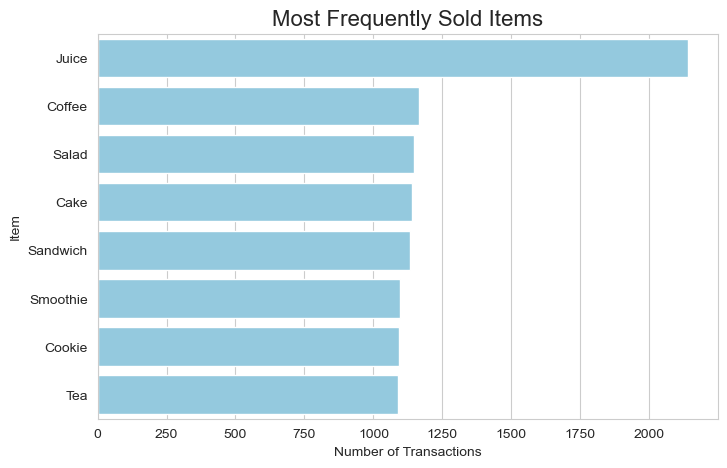

In [19]:
# 1.1 Most frequently sold items
item_counts = df['Item'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=item_counts.values, y=item_counts.index, color='skyblue')
plt.title('Most Frequently Sold Items', fontsize=16)
plt.xlabel('Number of Transactions')
plt.ylabel('Item')
plt.show()

#### 1.2. Which items generate the most total revenue?

While some items may be frequently sold, they may not necessarily bring in the most money. Here, I calculated revenue as:


In [20]:
# Create a new column:
df['Item Revenue'] = df['Price Per Unit'] * df['Quantity']

# Group by Item and calculate total revenue
revenue_by_item = df.groupby('Item')['Item Revenue'].sum().sort_values(ascending=False).head(10)

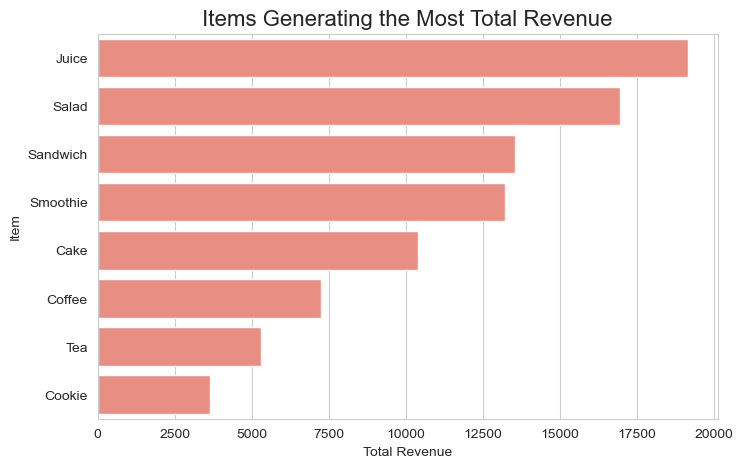

In [21]:
## 1.2 Items generating the most total revenue
item_revenue = df.groupby('Item')['Total Spent'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=revenue_by_item.values, y=revenue_by_item.index, color='salmon')
plt.title('Items Generating the Most Total Revenue', fontsize=16)
plt.xlabel('Total Revenue')
plt.ylabel('Item')
plt.show()


#### 2.1 Which days of the week have the highest sales activity?

Using the `Transaction Date` column, I created a new column called `Day of Week` during the cleaning phase.

Here, I grouped transactions by day and summed the total sales. This chart helps identify which days bring in the most revenue — useful for scheduling, staffing, and marketing campaigns.

Consistent spikes on certain days could suggest customer routines or promotional opportunities.


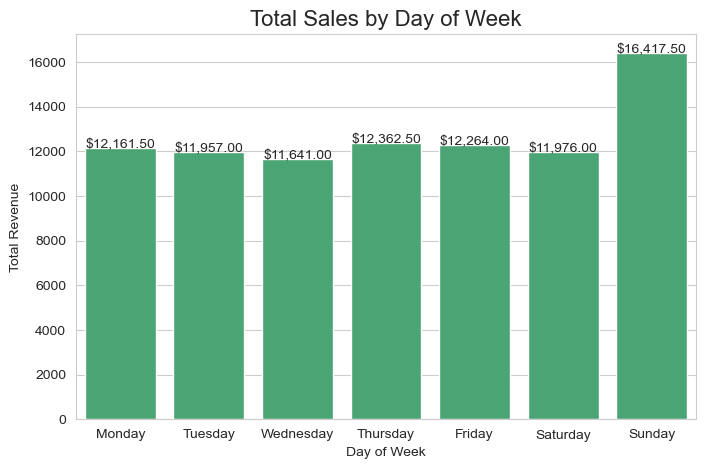

In [22]:
## 2.1 Sales by Day of the Week
day_sales = df.groupby('Day of Week')['Total Spent'].sum()
# Order days Monday → Sunday
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_sales = day_sales.reindex(days_order)

plt.figure(figsize=(8,5))
sns.barplot(x=day_sales.index, y=day_sales.values, color='mediumseagreen')
plt.title('Total Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue')
for i, v in enumerate(day_sales.values):
    plt.text(i, v + 5, f"${v:,.2f}", ha='center')
plt.show()

#### 2.2 How do monthly sales compare?

To understand seasonal trends or monthly performance, I grouped transactions by the `Month` column (extracted earlier from the transaction date).

This chart visualizes total café revenue across the months in the dataset. Patterns here could reveal high-traffic seasons, slow periods, or opportunities for special promotions.


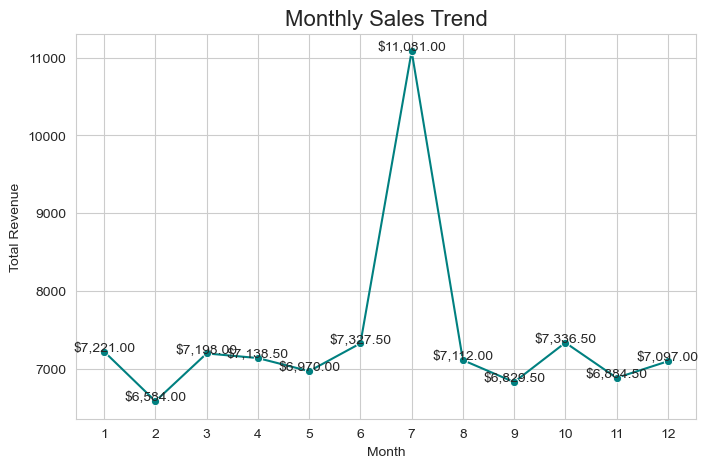

In [23]:
## 2.2 Monthly sales comparison
month_sales = df.groupby('Month')['Total Spent'].sum()

plt.figure(figsize=(8,5))
sns.lineplot(x=month_sales.index, y=month_sales.values, marker='o', color='teal')
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(range(1,13))
for i, v in enumerate(month_sales.values):
    plt.text(i+1, v + 5, f"${v:,.2f}", ha='center')
plt.show()

#### 3.1 What are the most commonly used payment methods?

This chart shows how customers typically pay at the café - whether via card, cash, or other methods.

Understanding popular payment types is useful for day-to-day operations (e.g., keeping enough change) and enhancing the customer experience (e.g., enabling digital wallets).


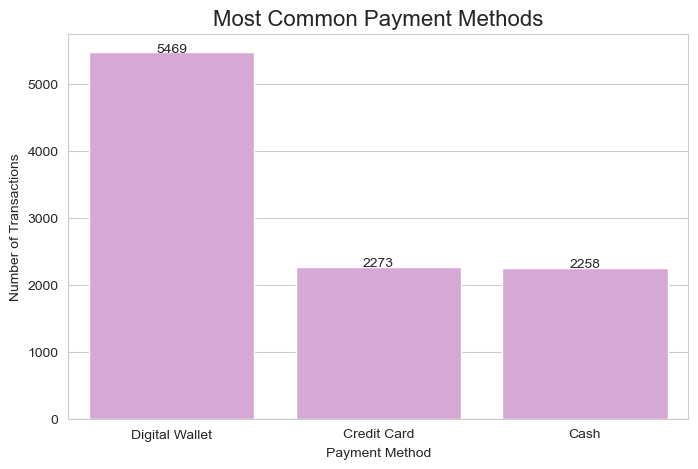

In [24]:
## 3.1 Most commonly used payment methods
payment_counts = df['Payment Method'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=payment_counts.index, y=payment_counts.values, color='plum')
plt.title('Most Common Payment Methods', fontsize=16)
plt.xlabel('Payment Method')
plt.ylabel('Number of Transactions')
for i, v in enumerate(payment_counts.values):
    plt.text(i, v + 2, str(v), ha='center')
plt.show()

#### 3.2 Do customers spend differently depending on payment method?

Here, I compared the **average transaction value** across different payment methods.

This can offer insight into customer behavior — for example, card or mobile payments might be linked to higher spending than cash.

Such patterns could help inform marketing, payment system decisions, and even loyalty program targeting.


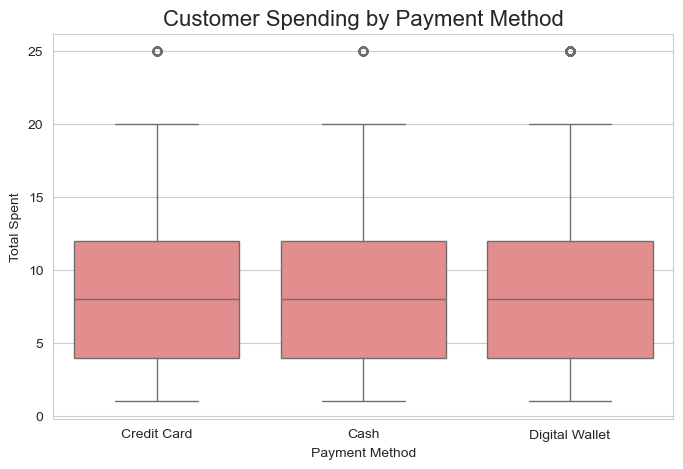

In [25]:
## 3.2 Spending by payment method
plt.figure(figsize=(8,5))
sns.boxplot(x='Payment Method', y='Total Spent', data=df, color='lightcoral')
plt.title('Customer Spending by Payment Method', fontsize=16)
plt.xlabel('Payment Method')
plt.ylabel('Total Spent')
plt.show()

In [26]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv('cafe_sales_cleaned.csv')

# Ensure necessary datetime features exist
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['DayOfWeek'] = df['Transaction Date'].dt.day_name()
df['Month'] = df['Transaction Date'].dt.month
df['Year'] = df['Transaction Date'].dt.year

# ------------------------------
# 1. Sales Insights
# ------------------------------

## 1.1 Most frequently sold items
item_freq = df['Item'].value_counts()
print("1.1 Most Frequently Sold Items:")
print(item_freq)
print("\nTop 5 items:\n", item_freq.head())

## 1.2 Items generating the most total revenue
item_revenue = df.groupby('Item')['Total Spent'].sum().sort_values(ascending=False)
print("\n1.2 Items Generating the Most Revenue:")
print(item_revenue)
print("\nTop 5 revenue-generating items:\n", item_revenue.head())

# ------------------------------
# 2. Time-Based Patterns
# ------------------------------

## 2.1 Which days of the week have the highest sales activity?
day_sales = df.groupby('DayOfWeek')['Total Spent'].sum()
# Order days Monday → Sunday
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_sales = day_sales.reindex(days_order)
print("\n2.1 Total Sales by Day of Week:")
print(day_sales)
print("\nDay with highest sales:", day_sales.idxmax(), "Revenue:", day_sales.max())

## 2.2 How do monthly sales compare?
month_sales = df.groupby('Month')['Total Spent'].sum()
print("\n2.2 Total Sales by Month:")
print(month_sales)
print("\nMonth with highest sales:", month_sales.idxmax(), "Revenue:", month_sales.max())

# ------------------------------
# 3. Customer Behavior
# ------------------------------

## 3.1 Most commonly used payment methods
payment_counts = df['Payment Method'].value_counts()
print("\n3.1 Payment Method Frequency:")
print(payment_counts)
print("\nMost common payment method:", payment_counts.idxmax(), "Transactions:", payment_counts.max())

## 3.2 Do customers spend differently depending on payment method?
payment_avg_spend = df.groupby('Payment Method')['Total Spent'].mean().sort_values(ascending=False)
print("\n3.2 Average Spending by Payment Method:")
print(payment_avg_spend)
print("\nHighest average spending payment method:", payment_avg_spend.idxmax(), "Average Spent:", payment_avg_spend.max())


1.1 Most Frequently Sold Items:
Item
Juice       2140
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
Name: count, dtype: int64

Top 5 items:
 Item
Juice       2140
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Name: count, dtype: int64

1.2 Items Generating the Most Revenue:
Item
Juice       18972.0
Salad       17021.0
Sandwich    13484.0
Smoothie    13132.0
Cake        10341.0
Coffee       7184.0
Tea          5119.5
Cookie       3526.0
Name: Total Spent, dtype: float64

Top 5 revenue-generating items:
 Item
Juice       18972.0
Salad       17021.0
Sandwich    13484.0
Smoothie    13132.0
Cake        10341.0
Name: Total Spent, dtype: float64

2.1 Total Sales by Day of Week:
DayOfWeek
Monday       12161.5
Tuesday      11957.0
Wednesday    11641.0
Thursday     12362.5
Friday       12264.0
Saturday     11976.0
Sunday       16417.5
Name: Total Spent, dtype: float64

Day with highest sales: Sunday Re